In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install -U pysal
import pysal as ps

import mgwr.gwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
import geopandas
from sklearn.preprocessing import StandardScaler, MinMaxScaler

C:\Users\frobb\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
crw_df= pd.read_csv('CRW_and_crop_intensity.csv')
WI_grid= pd.read_csv('WI_grid.csv')

#plt.hist(crw_df['Year'])

crw_df_train= crw_df[crw_df['Year'] < 2015]
crw_df_test= crw_df[crw_df['Year'] >= 2015]
crw_df= crw_df.drop(crw_df ['ID'])


gdf = geopandas.GeoDataFrame(
    crw_df, geometry=geopandas.points_from_xy(crw_df.lon, crw_df.lat), crs="EPSG:4326")
#crw= crw_df[['lon', 'lat']].unique()
#crw=pd.unique(crw_df[['lon', 'lat']].values.ravel('K'))
crw_df1 = crw_df.drop_duplicates(subset=['lon', 'lat'])
gdf1 = geopandas.GeoDataFrame(
    crw_df1, geometry=geopandas.points_from_xy(crw_df1.lon, crw_df1.lat), crs="EPSG:4326")


def min_traps(df, category, scaling_factor): 
    df= df.dropna()
    df_new= df.sort_values(by= category)
    old_mean= df[category].mean()
    norm_range= scaling_factor * df[category].std()
    
    while  df_new[category].mean() < old_mean+norm_range: 
        df_new= df_new.drop(df_new[category].idxmin())
    return df_new

In [5]:
gdf

,ID,intensity_1000,intensity_2500,intensity_5000,District,County,Year,meanTotCRW,meanNCRW,meanWCRW,lon,lat,geometry
0,1,3631.790962,3134.626895,2931.385444,C,Adams,1997,2.0,0.0,2.0,-89.727276,43.767269,POINT (-89.72728 43.76727)
13,1,3631.790962,3134.626895,2931.385444,C,Adams,2015,0.0,0.0,0.0,-89.667020,43.774340,POINT (-89.66702 43.77434)
14,1,3631.790962,3134.626895,2931.385444,C,Adams,2016,2.0,1.0,1.0,-89.666810,43.774170,POINT (-89.66681 43.77417)
15,1,3631.790962,3134.626895,2931.385444,C,Adams,2017,0.0,0.0,0.0,-90.161610,43.789230,POINT (-90.16161 43.78923)
16,1,3631.790962,3134.626895,2931.385444,C,Adams,2018,0.0,0.0,0.0,-89.897740,43.995010,POINT (-89.89774 43.99501)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4062,11,94.818256,94.252986,83.912454,SC,Dane,2017,12.0,12.0,0.0,-89.038970,42.881260,POINT (-89.03897 42.88126)
4063,11,94.818256,94.252986,83.912454,SC,Dane,2018,0.0,0.0,0.0,-89.068230,43.223470,POINT (-89.06823 43.22347)
4064,11,94.818256,94.252986,83.912454,SC,Dane,2019,11.0,11.0,0.0,-89.048270,43.226300,POINT (-89.04827 43.22630)
4065,11,94.818256,94.252986,83.912454,SC,Dodge,2005,13.0,8.0,4.0,-88.457580,43.587180,POINT (-88.45758 43.58718)


In [4]:
gdf1 = gdf1.to_crs(crs=3857)
#gdf1["centroid"] = gdf1["geometry"].centroid
from sklearn.neighbors import NearestNeighbors
import numpy as np

def distance(p1, p2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = p1
    lon2, lat2 = p2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

nbrs = NearestNeighbors(n_neighbors=2, metric=distance).fit(gdf1[['lon', 'lat']])

distances, indices = nbrs.kneighbors(gdf1[['lon', 'lat']])

dist= distances[:, 1]
dataframe=pd.DataFrame(dist, columns=['distances'])
gdf1['dist']= dataframe['distances']
gdf1= gdf1.dropna()

scaler = MinMaxScaler()
 
gdf2= gdf1[['intensity_1000', 'meanTotCRW', 'dist']]
    
df_scaled = scaler.fit_transform(gdf2.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'intensity_1000', 'meanTotCRW', 'dist'])
df_scaled['score']= df_scaled.mean(axis=1)
gdf1['site_score']= df_scaled['score']

gdf1.head()
#gdf1["distance"] = gdf1["centroid"].distance(first_point)
#df= gdf1.geometry.apply(lambda x: gdf1.distance(x).min())

,ID,intensity_1000,intensity_2500,intensity_5000,District,County,Year,meanTotCRW,meanNCRW,meanWCRW,lon,lat,geometry,dist,site_score
0,1,3631.790962,3134.626895,2931.385444,C,Adams,1997,2.0,0.0,2.0,-89.727276,43.767269,POINT (-9988394.666 5429496.910),1.403193,0.358523
13,1,3631.790962,3134.626895,2931.385444,C,Adams,2015,0.0,0.0,0.0,-89.667020,43.774340,POINT (-9981687.007 5430586.930),9.310216,0.370009
14,1,3631.790962,3134.626895,2931.385444,C,Adams,2016,2.0,1.0,1.0,-89.666810,43.774170,POINT (-9981663.630 5430560.722),0.005782,0.336778
15,1,3631.790962,3134.626895,2931.385444,C,Adams,2017,0.0,0.0,0.0,-90.161610,43.789230,POINT (-10036744.514 5432882.765),0.009208,0.333338
16,1,3631.790962,3134.626895,2931.385444,C,Adams,2018,0.0,0.0,0.0,-89.897740,43.995010,POINT (-10007370.640 5464670.002),0.033376,0.382268


In [4]:
coords = list(zip(crw_df_train['lon'], crw_df_train['lat']))
y= np.array(crw_df_train['meanTotCRW']).reshape((-1,1))
x= np.array(crw_df_train['intensity_5000']).reshape((-1,1))

bw = Sel_BW(coords, y, x).search(criterion='AICc')
print(bw)
model= GWR(coords, y, x, bw=100)


X_test = np.array(crw_df_test['intensity_5000']).reshape((-1,1))
coords_test = list(zip(crw_df_test['lon'], crw_df_test['lat']))
coords_test= np.array(coords)
#model = GWR(coords, y, X, bw=10)
results = model.fit()
predictions = model.predict(coords_test, X_test)
#results = model.predict(coords_test, X_test)

99.0


In [5]:
gdf1.to_csv('scored_points.csv')
WI_grid3.to_csv('scored_state.csv')

NameError: name 'WI_grid3' is not defined

In [ ]:
gdf1.plot('site_score', legend=True)
plt.title('Site Score Metric')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

In [7]:
gdf1.describe()

#df= gdf1.sample(2500)

df.plot('site_score', legend=True)
plt.title('Site Score Metric')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

NameError: name 'df' is not defined

In [8]:
df= df.dropna()

df= df.sort_values(by= 'site_score')
df.head(25)

county_scores = df.groupby('County')['site_score'].mean()
district_scores = df.groupby('District')['site_score'].mean()

NameError: name 'df' is not defined

In [10]:
print(team_mean_points)

df.groupby('District')['site_score'].mean()

NameError: name 'team_mean_points' is not defined

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [11]:
train= gdf1[gdf['Year'] < 2015]
test= gdf1[gdf['Year'] >= 2016]

coords_train = train[['lon', 'lat']]
coords_test = test[['lon', 'lat']]

value_train = train[['intensity_5000']]
value_test = test[['intensity_5000']]

neighbors = 10

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_train, value_train)

in_r_squared_knn = knn_regressor.score(coords_test, value_test)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

out_r_squared_knn = knn_regressor.score(coords_test, value_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

coords_test_predict_knn = knn_regressor.predict(coords_test)

#predict_dict_knn = {"Coordinate_Pair": coords_test, "VALUE_Actual": value_test, "VALUE_Predict": coords_test_predict_knn}

# Create dataframe from dictionary
#predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
#print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
#display(predict_df_knn.head(2))

coords_test_predict_knn1 = knn_regressor.predict(WI_grid[['lon', 'lat']])

pred1= pd.DataFrame(coords_test_predict_knn1,columns= ['pred_intensity'])

WI_grid['pred_intensity']=pred1['pred_intensity']

KNN in-sample r-squared: 0.62
KNN out-of-sample r-squared: 0.62


C:\Users\frobb\anaconda3\lib\site-packages\geopandas\geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
C:\Users\frobb\anaconda3\lib\site-packages\geopandas\geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [12]:
value_train = train[['meanTotCRW']]
value_test = test[['meanTotCRW']]

neighbors = 10

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_train, value_train)

in_r_squared_knn = knn_regressor.score(coords_test, value_test)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

out_r_squared_knn = knn_regressor.score(coords_test, value_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

coords_test_predict_knn = knn_regressor.predict(coords_test)

#predict_dict_knn = {"Coordinate_Pair": coords_test, "VALUE_Actual": value_test, "VALUE_Predict": coords_test_predict_knn}

# Create dataframe from dictionary
#predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
#print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
#display(predict_df_knn.head(2))

coords_test_predict_knn2 = knn_regressor.predict(WI_grid[['lon', 'lat']])

pred2= pd.DataFrame(coords_test_predict_knn2,columns= ['pred_crw'])

WI_grid['pred_crw']=pred2['pred_crw']

KNN in-sample r-squared: -1.95
KNN out-of-sample r-squared: -1.95


In [13]:
nbrs = NearestNeighbors(n_neighbors=2, metric=distance).fit(WI_grid[['lon', 'lat']])

distances, indices = nbrs.kneighbors(WI_grid[['lon', 'lat']])

dist= distances[:, 1]
dataframe=pd.DataFrame(dist, columns=['distances'])
WI_grid['dist']= dataframe['distances']
WI_grid= WI_grid.dropna()


scaler = MinMaxScaler()
 
WI_grid1= WI_grid[['pred_intensity', 'pred_crw', 'dist']]
    
df_scaled1 = scaler.fit_transform(WI_grid1.to_numpy())

df_scaled1 = pd.DataFrame(df_scaled1, columns=[
  'pred_intensity', 'pred_crw', 'dist'])

df_scaled1['score']= df_scaled1.mean(axis=1)
WI_grid1['site_score']= df_scaled1['score']

WI_grid1[['lon', 'lat']]= WI_grid[['lon', 'lat']]

C:\Users\frobb\AppData\Local\Temp\ipykernel_15960\865240639.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WI_grid1['site_score']= df_scaled1['score']


Text(95.63128246228699, 0.5, 'Latitude')

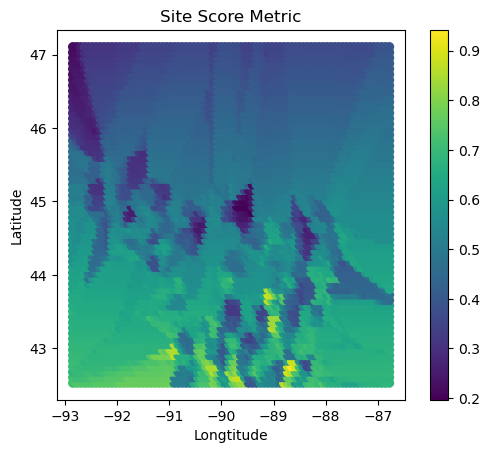

In [14]:
WI_grid3 = geopandas.GeoDataFrame(
    WI_grid1, geometry=geopandas.points_from_xy(WI_grid1.lon, WI_grid1.lat), crs="EPSG:4326")

WI_grid3.plot('site_score', legend=True)
plt.title('Site Score Metric')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

In [16]:
WI_grid3.describe()

,pred_intensity,pred_crw,dist,site_score,lon,lat
count,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000
mean,2637.152821,6.377136,5.910473,0.507781,-89.814241,44.816966
std,490.769086,4.728420,0.137608,0.121929,1.775395,1.342297
min,822.365985,0.049793,5.672913,0.196725,-92.851741,42.529466
25%,2588.643461,3.606489,5.791697,0.416908,-91.351741,43.654466
50%,2899.204160,5.229161,5.912094,0.489601,-89.814241,44.816966
75%,2931.385444,7.899900,6.030059,0.612733,-88.276741,45.979466
max,2931.385444,40.540407,6.141855,0.941304,-86.776741,47.104466


In [1]:
df.describe()

NameError: name 'df' is not defined

In [6]:
gdf1_sorted= gdf1.sort_values(by= 'site_score')
gdf1_sorted= gdf1_sorted.dropna()
gdf1_sorted.tail(5)


WI_grid3_sorted= WI_grid3.sort_values(by= 'site_score')
WI_grid3_sorted

NameError: name 'WI_grid3' is not defined

In [7]:
gdf1_sorted

,ID,intensity_1000,intensity_2500,intensity_5000,District,County,Year,meanTotCRW,meanNCRW,meanWCRW,lon,lat,geometry,dist,site_score
3466,5,1441.631608,1269.672418,1218.497874,SW,Iowa,2009,1.0,1.0,0.0,-89.92109,42.93884,POINT (-10009969.950 5302667.300),1.909657,0.006944
3320,5,1441.631608,1269.672418,1218.497874,NW,Chippewa,2009,7.0,7.0,0.0,-91.10064,45.17754,POINT (-10141276.856 5649514.964),0.017493,0.020185
3327,5,1441.631608,1269.672418,1218.497874,NW,Chippewa,2016,2.0,0.0,2.0,-91.08784,45.17758,POINT (-10139851.966 5649521.281),1.790882,0.020201
3288,5,1441.631608,1269.672418,1218.497874,NC,Marathon,2007,15.0,13.0,2.0,-89.84059,44.85804,POINT (-10001008.731 5599200.407),0.004095,0.020228
3416,5,1441.631608,1269.672418,1218.497874,SC,Rock,2011,38.0,11.0,27.0,-89.01256,42.59869,POINT (-9908832.853 5251086.497),1.606285,0.020232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1,3631.790962,3134.626895,2931.385444,SW,Grant,2005,30.0,11.0,19.0,-90.97249,42.94921,POINT (-10127011.263 5304244.284),0.014804,0.555664
1641,2,3618.987361,3183.255340,2895.627969,SE,Kenosha,2016,0.0,0.0,0.0,-88.05001,42.53370,POINT (-9801682.278 5241263.427),0.008810,0.608786
1642,2,3618.987361,3183.255340,2895.627969,SE,Kenosha,2017,0.0,0.0,0.0,-88.08356,42.58294,POINT (-9805417.046 5248704.985),0.083666,0.617873
654,1,3631.790962,3134.626895,2931.385444,SC,Rock,2011,44.0,5.0,39.0,-89.28608,42.71595,POINT (-9939280.961 5268835.997),0.175307,0.626415


In [8]:
table1= gdf1_sorted[['District', 'site_score']]
table1
table1.groupby('District').describe()

site_score                                                    \
              count      mean       std       min       25%       50%   
District                                                                
C             319.0  0.333337  0.063295  0.081964  0.332034  0.339957   
EC            485.0  0.297151  0.092671  0.081635  0.242277  0.334183   
NC            220.0  0.271413  0.118528  0.020228  0.173445  0.333462   
NE            181.0  0.304055  0.113049  0.020381  0.249707  0.337380   
NW            241.0  0.291602  0.097171  0.020185  0.240707  0.334226   
SC            493.0  0.239976  0.129092  0.020232  0.108296  0.250970   
SE            310.0  0.302137  0.110987  0.020719  0.255402  0.336938   
SW            424.0  0.266697  0.116193  0.006944  0.152211  0.333854   
WC            515.0  0.249420  0.095748  0.081706  0.158606  0.247113   

                              
               75%       max  
District                      
C         0.356123  0.552341  
EC        0.351767  0.489294  
NC        0.344242  0.513052  
NE        0.356344  0.672764  
NW        0.346329  0.524390  
SC        0.343926  0.626415  
SE        0.357734  0.617873  
SW        0.348827  0.555664  
WC        0.335481  0.547686

In [9]:
def funky(df_old, pred_grid): 
    df_new= df_old.head(25).replace(pred_grid.tail(25))
    for val in df_old['site_score']:
        if (df_old['site_score'].mean() + (2 * df_old['site_score'].std())) > df_new['site_score'].mean():
            df_new[min(df_new['site_score'])].replace(max((pred_grid['site_score'])))
            #df_new['site_score'].tail(5).replace(pred_grid['site_score'].head(5))
            #df_new['site_score'].tail(5).replace(pred_grid['site_score'].head(5))
    return df_new

In [18]:
def min_traps(df, category, scaling_factor): 
    df= df.dropna()
    df_new= df.sort_values(by= category)
    #df_new= df_new.dropna()
    old_mean= df[category].mean()
    norm_range= scaling_factor * df[category].std()
    
    while  df_new[category].mean() < old_mean+norm_range: 
        df_new= df_new.drop(df_new[category].idxmin())
    return df_new

gdf_minimized= min_traps(gdf1, 'site_score', 1)

In [19]:
def replace_low_scoring(df, pred_grid, n_rows): 
    df= df.dropna()
    df= df.sort_values(by= 'site_score', ascending=True) 
    pred_grid= pred_grid.dropna()
    pred_grid= pred_grid.sort_values(by= 'site_score', ascending=False)
    
    df
         
    for val in df_old['site_score']:
        if (df_old['site_score'].mean() + (2 * df_old['site_score'].std())) > df_new['site_score'].mean():
            df_new[min(df_new['site_score'])].replace(max((pred_grid['site_score'])))
            #df_new['site_score'].tail(5).replace(pred_grid['site_score'].head(5))
            #df_new['site_score'].tail(5).replace(pred_grid['site_score'].head(5))
    return df_new

In [20]:
#gdf_minimized['site_score'].idxmin()

gdf_minimized= gdf_minimized.sort_values(by= 'site_score', ascending=False) 
gdf_minimized.head()

,ID,intensity_1000,intensity_2500,intensity_5000,District,County,Year,meanTotCRW,meanNCRW,meanWCRW,lon,lat,geometry,dist,site_score
444,1,3631.790962,3134.626895,2931.385444,NE,Shawano,2017,4.0,0.0,4.0,-89.04152,44.95516,POINT (-9912056.666 5614465.106),0.003852,0.672764
654,1,3631.790962,3134.626895,2931.385444,SC,Rock,2011,44.0,5.0,39.0,-89.28608,42.71595,POINT (-9939280.961 5268835.997),0.175307,0.626415
1642,2,3618.987361,3183.255340,2895.627969,SE,Kenosha,2017,0.0,0.0,0.0,-88.08356,42.58294,POINT (-9805417.046 5248704.985),0.083666,0.617873
1641,2,3618.987361,3183.255340,2895.627969,SE,Kenosha,2016,0.0,0.0,0.0,-88.05001,42.53370,POINT (-9801682.278 5241263.427),0.008810,0.608786
792,1,3631.790962,3134.626895,2931.385444,SW,Grant,2005,30.0,11.0,19.0,-90.97249,42.94921,POINT (-10127011.263 5304244.284),0.014804,0.555664


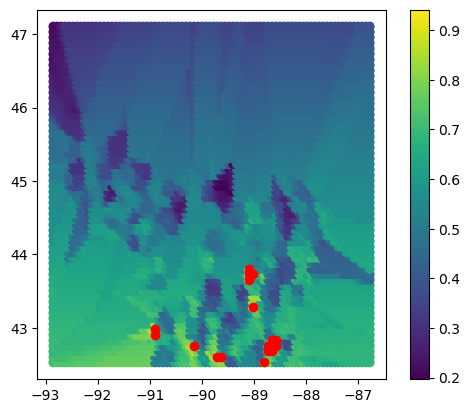

In [21]:
WI_grid4= WI_grid3[WI_grid3['site_score']>.85]

WI_grid3.plot('site_score', legend=True)
plt.scatter(WI_grid4['lon'], WI_grid4['lat'], c='r')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
gdf1_sorted.head()

,ID,intensity_1000,intensity_2500,intensity_5000,District,County,Year,meanTotCRW,meanNCRW,meanWCRW,lon,lat,geometry,dist,site_score
3466,5,1441.631608,1269.672418,1218.497874,SW,Iowa,2009,1.0,1.0,0.0,-89.92109,42.93884,POINT (-10009969.950 5302667.300),1.909657,0.006944
3320,5,1441.631608,1269.672418,1218.497874,NW,Chippewa,2009,7.0,7.0,0.0,-91.10064,45.17754,POINT (-10141276.856 5649514.964),0.017493,0.020185
3327,5,1441.631608,1269.672418,1218.497874,NW,Chippewa,2016,2.0,0.0,2.0,-91.08784,45.17758,POINT (-10139851.966 5649521.281),1.790882,0.020201
3288,5,1441.631608,1269.672418,1218.497874,NC,Marathon,2007,15.0,13.0,2.0,-89.84059,44.85804,POINT (-10001008.731 5599200.407),0.004095,0.020228
3416,5,1441.631608,1269.672418,1218.497874,SC,Rock,2011,38.0,11.0,27.0,-89.01256,42.59869,POINT (-9908832.853 5251086.497),1.606285,0.020232


In [16]:
WI_grid3

,pred_intensity,pred_crw,dist,site_score,lon,lat,geometry
0,2924.251637,6.595569,6.141855,0.719426,-92.851741,42.529466,POINT (-92.85174 42.52947)
1,2924.249152,8.591423,6.141855,0.735857,-92.776741,42.529466,POINT (-92.77674 42.52947)
2,2924.246508,8.594512,6.141855,0.735882,-92.701741,42.529466,POINT (-92.70174 42.52947)
3,2920.680519,8.597987,6.141855,0.735347,-92.626741,42.529466,POINT (-92.62674 42.52947)
4,2920.677881,8.600270,6.141855,0.735365,-92.551741,42.529466,POINT (-92.55174 42.52947)
...,...,...,...,...,...,...,...
5079,2924.236158,4.296850,5.672913,0.367167,-87.076741,47.104466,POINT (-87.07674 47.10447)
5080,2913.573867,6.881405,5.672913,0.386758,-87.001741,47.104466,POINT (-87.00174 47.10447)
5081,2910.002881,7.681173,5.672913,0.392778,-86.926741,47.104466,POINT (-86.92674 47.10447)
5082,2909.987010,7.684841,5.672913,0.392806,-86.851741,47.104466,POINT (-86.85174 47.10447)


In [17]:
WI_grid_df= WI_grid3[['pred_intensity', 'pred_crw', 'dist', 'lon', 'lat', 'site_score']]

In [18]:

#WI_grid3 = WI_grid3.iloc[:,:-1]
WI_grid3
#WI_grid3.drop(WI_grid3['geometry'])
scaled_df = StandardScaler().fit_transform(WI_grid_df)


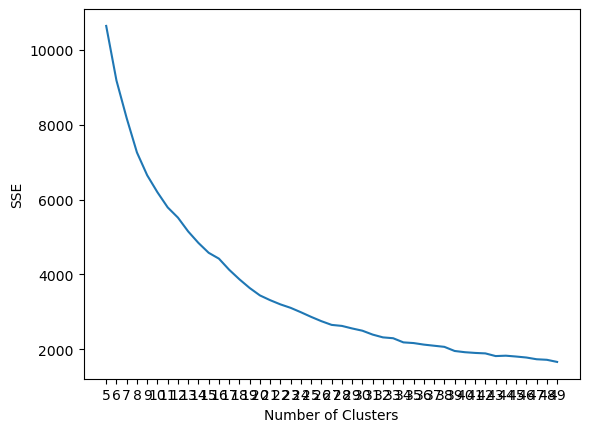

In [19]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(5, 50):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(5,50), sse)
plt.xticks(range(5,50))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [36]:
kmeans = KMeans(init="random", n_clusters=5, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_df)

#view cluster assignments for each observation
kmeans.labels_

WI_grid_df['cluster'] = kmeans.labels_

Text(95.63128246228699, 0.5, 'Latitude')

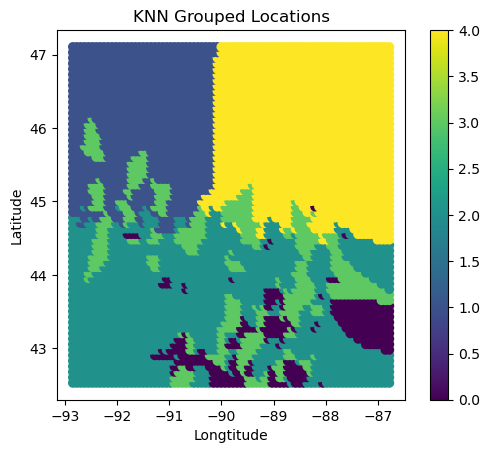

In [37]:
WI_grid_gdf = geopandas.GeoDataFrame(
    WI_grid_df, geometry=geopandas.points_from_xy(WI_grid_df.lon, WI_grid_df.lat), crs="EPSG:4326")

WI_grid_gdf.plot('cluster', legend=True)
#plt.scatter(WI_grid_df['lon'], WI_grid_df['lat'], c= WI_grid_df['cluster'])
plt.title('KNN Grouped Locations')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

In [38]:
WI_grid_gdf
WI_grid_gdf.to_csv('knn_grid.csv')

In [29]:
WI_grid3 = WI_grid3[WI_grid3['cluster'] == 6]
WI_grid3

,pred_intensity,pred_crw,dist,site_score,lon,lat,cluster
36,2350.059818,26.557460,6.141855,0.793008,-90.151741,42.529466,6
37,2350.059818,24.409193,6.141855,0.775323,-90.076741,42.529466,6
38,2169.540524,18.697799,6.141855,0.699773,-90.001741,42.529466,6
41,2123.434860,26.994066,6.141855,0.760784,-89.776741,42.529466,6
42,2350.059818,26.231084,6.141855,0.790321,-89.701741,42.529466,6
...,...,...,...,...,...,...,...
2100,2859.278166,16.945147,5.954235,0.660994,-89.101741,44.404466,6
2183,2907.923446,16.943690,5.946596,0.663241,-89.026741,44.479466,6
2228,2172.993825,16.544235,5.938947,0.538359,-91.801741,44.554466,6
2267,2902.154486,13.762080,5.938947,0.630700,-88.876741,44.554466,6


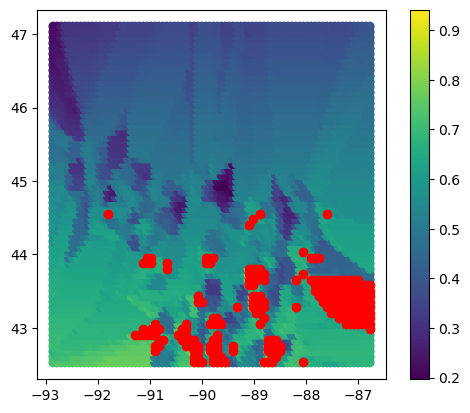

In [34]:
WI_grid_df.plot('site_score', legend=True)
plt.scatter(WI_grid3['lon'], WI_grid3['lat'], c='r')

# Sensitivity Analysis

In [30]:
WI_grid_df.describe()
WI_grid_df1= WI_grid_df[['pred_intensity', 'pred_crw', 'dist', 'lon', 'lat', 'site_score']]

In [31]:
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 6,
    'names': ['pred_intensity', 'pred_crw', 'dist', 'lon', 'lat', 'site_score'],
    'bounds': [[400, 3500],
              [0,45],
               [5, 7],
              [-93,-86],
               [42,48],
               [0,1]
              ]
}

# Generate samples
param_values = sample(problem, 10000)

# Run model (example)
#Y = old_pred_labels#Ishigami.evaluate(param_values)
Y = kmeans.predict(param_values)
# Perform analysis
Si = analyze(problem, Y, print_to_console=True)

# Print the first-order sensitivity indices
print(Si['S1'])

C:\Users\frobb\anaconda3\lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
C:\Users\frobb\anaconda3\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                      ST   ST_conf
pred_intensity  0.995195  0.022489
pred_crw        0.061979  0.007566
dist            0.007101  0.002701
lon             0.008221  0.002810
lat             0.033599  0.005850
site_score      0.002240  0.001555
                      S1   S1_conf
pred_intensity  0.922515  0.026691
pred_crw       -0.000471  0.006062
dist           -0.001292  0.002320
lon            -0.001292  0.001932
lat            -0.001902  0.004617
site_score      0.000560  0.001484
                                    S2   S2_conf
(pred_intensity, pred_crw)    0.039018  0.034640
(pred_intensity, dist)        0.004859  0.034972
(pred_intensity, lon)         0.005979  0.034545
(pred_intensity, lat)         0.016059  0.034032
(pred_intensity, site_score)  0.002059  0.034846
(pred_crw, dist)              0.000862  0.009886
(pred_crw, lon)               0.001422  0.009843
(pred_crw, lat)              -0.000258  0.009830
(pred_crw, site_score)        0.000302  0.009901
(dist, lon)         

In [32]:
Si['S1']

array([ 9.22515027e-01, -4.71069845e-04, -1.29181305e-03, -1.29181305e-03,
       -1.90224435e-03,  5.59985266e-04])